# Detecting point cloud corners

In [2]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

import sklearn.linear_model as lm
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from skimage.transform import probabilistic_hough_line
from skimage import draw
import cv2

import warnings
warnings.filterwarnings("ignore")

## Visualising 3d point-cloud data

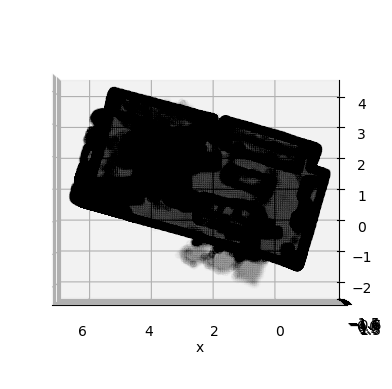

In [4]:
%matplotlib inline
df = pd.read_csv('zips/patron_1_ort.xyz', sep=' ')
df = df.drop(df.columns[3:], axis=1)
mat = df.to_numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mat[:,0], mat[:,1], mat[:,2], zdir='z', c='k', alpha=0.002, cmap='Greys')
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('x')
ax.view_init(elev=0, azim=90)
plt.show()#np.abs(mat[:,2])/np.max(mat)

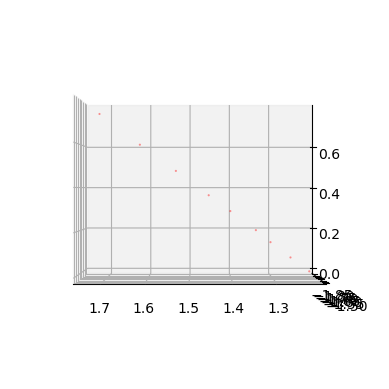

In [68]:
def find_ceiling(col_num, df, n_divs):
    """Finds the coordinates of the ceiling points"""
    points = np.zeros((1, 3))

    col = df.columns[col_num]
    n_iter = len(df[col]) // n_divs
    ordf = df.sort_values(by=[col])

    # Reversed to capture ceiling rather than wall
    # for i in reversed(range(n_iter)):
    for i in range(n_iter):
        # Interval of points
        temp = ordf[i*n_divs:(i+1)*n_divs]

        # The index that gives the highest z value
        idx = temp[df.columns[2]].idxmin()

        # Extracts the [x y z] array from dataframe
        current = df.iloc[idx].to_numpy().copy()

        # If current point isn't increasing,
        # it isn't recorded
        if np.max(points[:,2]) < current[2]:
            # Append to list
            points = np.vstack((points,current))
    
    # Remove 0s at the start that are appended to
    points = points[1:,:]
    return points

indices = find_ceiling(0, df, 2000)
# ind2 = find_ceiling('Exported', 250)
# indices = np.vstack((ind1, ind2))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(indices[:,0], indices[:,1], indices[:,2], color='r', s=0.3, alpha=0.4)
ax.view_init(elev=0, azim=90)
plt.show()

Equation: 0 = -1.76 + 1.46x + -0.00y - z


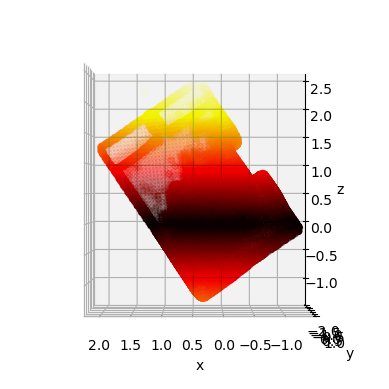

In [36]:
X_train = indices[:, :2]
y_train = indices[:, 2]
X_test = np.random.rand(200).reshape(100,2)*60

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], y_train, marker='.', color='red')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

model = lm.LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

xrange = indices[:,0]
yrange = indices[:,1]

x = np.linspace(np.min(xrange), np.max(xrange))
y = np.linspace(np.min(yrange), np.max(yrange))

coefs = model.coef_
intercept = model.intercept_
xs = np.tile(x, (len(x),1))
ys = np.tile(y, (len(y),1)).T
zs = xs*coefs[0]+ys*coefs[1]+intercept
print("Equation: 0 = {:.2f} + {:.2f}x + {:.2f}y - z".format(intercept, coefs[0],
                                                          coefs[1]))

ax.plot_surface(xs,ys,zs, alpha=0.5)
ax.scatter(mat[:,0], mat[:,1], mat[:,2], zdir='z', c=np.abs(mat[:,2])/np.max(mat), alpha=0.01, cmap='hot')
ax.set_aspect('equal', 'box')
ax.view_init(elev=0, azim=90)
plt.show()

In [73]:
def create_rot_mat(coefs):
    norm = -np.array([coefs[0], coefs[1], -1])
    norm = norm / np.linalg.norm(norm)
    basis_x = np.array([0, 0, 1])
    axis = np.cross(norm, basis_x)
    axis = axis / np.linalg.norm(axis)
    angle = -np.arccos(np.dot(norm, basis_x))
    C = np.array([[0, -axis[2], axis[1]],
                [axis[2], 0, -axis[0]],
                [-axis[1], axis[0], 0]])
    return np.identity(3) + np.sin(angle)*C + (1-np.cos(angle))*np.dot(C, C)

rot_mat = create_rot_mat(coefs)
inv_rot = np.linalg.inv(rot_mat)
mat2d = np.dot(inv_rot, mat.T).T

ceil = mat2d[mat2d[:, 1].argsort()]#[int(len(df.index)//(1.3))]
ceil

array([[ 2.01761838, -1.93936323,  0.00209433],
       [ 2.01761838, -1.93936323,  0.00209433],
       [ 2.01761838, -1.93936323,  0.00209433],
       ...,
       [ 1.95050488,  0.94174231,  0.64993576],
       [ 1.95050488,  0.94174231,  0.64993576],
       [ 1.95050488,  0.94174231,  0.64993576]])

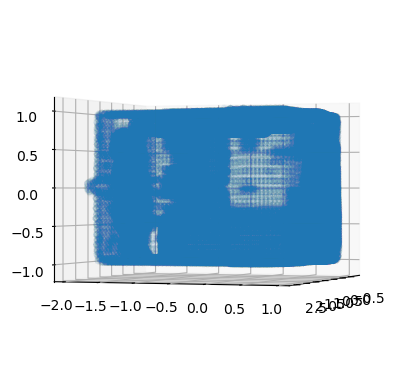

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ceil[:,0], ceil[:,1], ceil[:,2], alpha=0.01, cmap='hot')

ax.view_init(elev=0, azim=20)
plt.show()

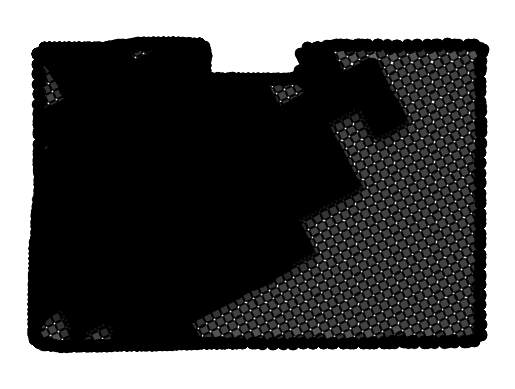

In [54]:
%matplotlib inline

plt.scatter(ceil[:,0], ceil[:, 2], color='k', alpha=0.2, s=50)
plt.axis('equal')
plt.axis('off')
plt.savefig('._.png')
plt.show()

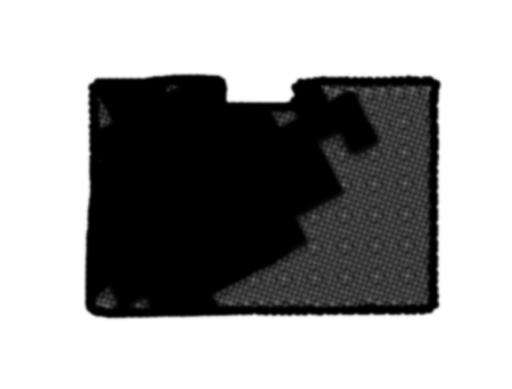

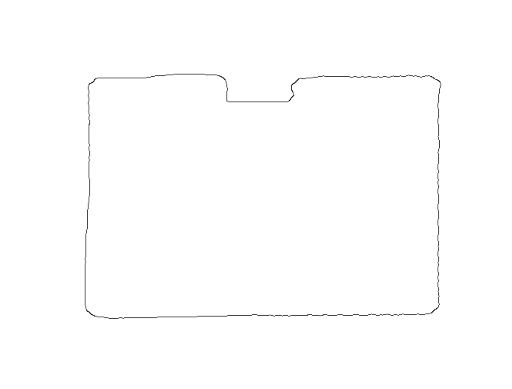

In [59]:
image = cv2.imread('._.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9, 9), 0)
# blur = cv2.bilateralFilter(gray,100,100,10000)
# blur = gray
sigma = np.std(blur)
mean = np.mean(blur)
lower = int(max(0, (mean - sigma)))
upper = int(min(255, (mean + sigma)))

edge = cv2.Canny(blur, 200, 300)
# edge = np.uint8((255 - cv2.Canny(gray, 200, 300, apertureSize=3)) // 255)
plt.imshow(blur, cmap='Greys_r')
plt.axis('off')
plt.show()

plt.imshow(edge, cmap='Greys')
plt.axis('off')
plt.show()

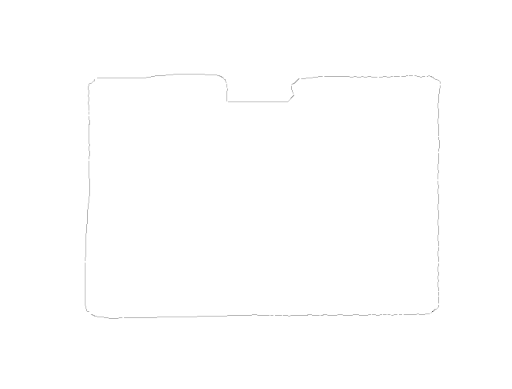

179


In [60]:
lines = probabilistic_hough_line(edge, threshold=1, line_length=2, line_gap=0)
restored = np.zeros_like(edge, dtype=np.uint8)
for line in lines:
    p0, p1 = line
    rr, cc = draw.line(p0[1], p0[0], p1[1], p1[0])
    restored[rr, cc] += 1
plt.imshow(restored, cmap='Greys')
plt.axis('off')
plt.show()

length = len(lines)
starts = np.vstack((np.array(([[i[0][0],i[0][1]] for i in lines])), np.array([[i[1][0],i[1][1]] for i in lines])))
grad = np.array([[np.abs(i[1][0]-i[0][0]),np.abs(i[1][1]-i[0][1])] for i in lines])
norms = np.sqrt(grad[:,0]**2 + grad[:,1]**2)[:, np.newaxis]
norms = np.hstack((norms, norms)) + 0.001
grad = grad / norms
print(length)

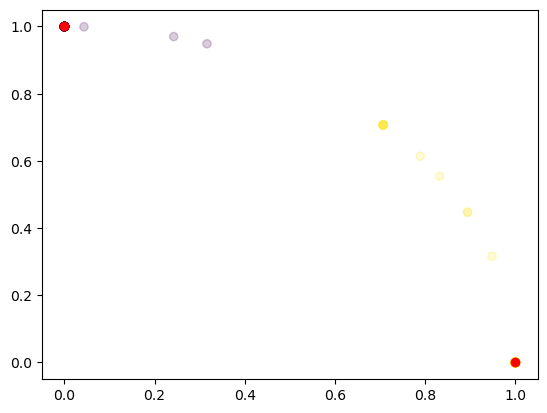

In [61]:
km = KMeans(n_clusters=2).fit(grad)
labels = km.labels_

class_grad = np.hstack((grad, labels[:, np.newaxis]))
class_size = np.hstack((starts, np.hstack((labels,labels))[:, np.newaxis]))

b0 = np.round(np.mean(class_grad[class_grad[:,2] == 0.][:,:2], axis=0))
b1 = np.round(np.mean(class_grad[class_grad[:,2] == 1.][:,:2], axis=0))

plt.scatter(grad[:,0], grad[:,1], c=labels, alpha=0.2)
plt.scatter(b0[0], b0[1], c='r')
plt.scatter(b1[0], b1[1], c='r')
plt.show()

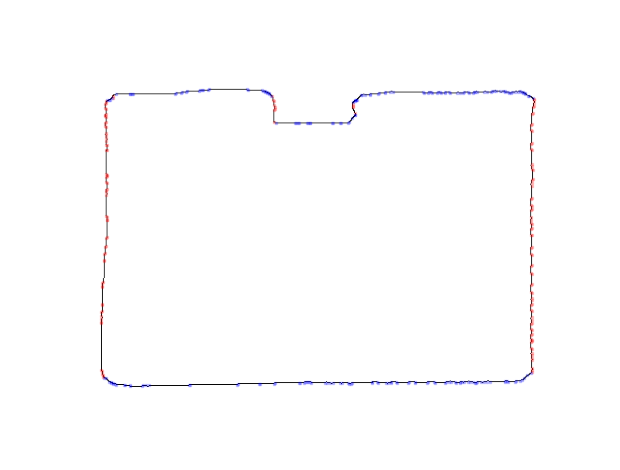

In [62]:
starts0 = class_size[class_size[:,2] == 0.][:,:2]
starts1 = class_size[class_size[:,2] == 1.][:,:2]
shifted0 = starts0 + np.tile(b0, (len(starts0), 1))
shifted1 = starts1 + np.tile(b1, (len(starts1), 1))
plt.scatter(starts0[:,0], starts0[:,1], c='r', marker='s', s=1, alpha=0.2)
plt.scatter(starts1[:,0], starts1[:,1], c='b', marker='s', s=1, alpha=0.2)
# plt.scatter(shifted0[:,0], shifted0[:,1], c='r', marker='s', s=1)
# plt.scatter(shifted1[:,0], shifted1[:,1], c='b', marker='s', s=1)
plt.imshow(edge, cmap='Greys')
plt.axis('off')
plt.tight_layout()
plt.show()

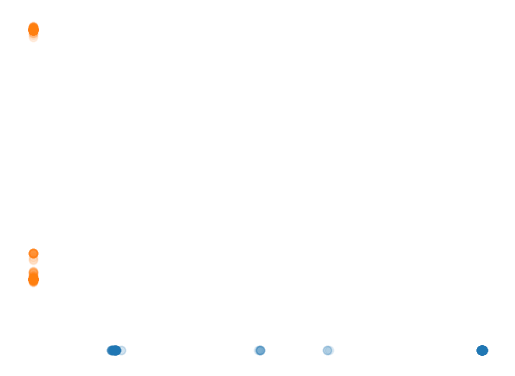

In [63]:
def _kmeans(mat, n_clusters=2):
    km = KMeans(n_clusters=n_clusters)
    km.fit(mat)
    km.predict(mat)
    return km.labels_

mult0 = np.tile((np.abs(b0 - 1)), (len(starts0), 1))
mult1 = np.tile((np.abs(b1 - 1)), (len(starts1), 1))
scaled0 = starts0 * mult0
scaled1 = starts1 * mult1
plt.scatter(scaled0[:,0], scaled0[:,1], alpha=0.1)
plt.scatter(scaled1[:,0], scaled1[:,1], alpha=0.1)
plt.gca().set_aspect('equal')
plt.axis('off')
plt.show()

0.9910591534607279


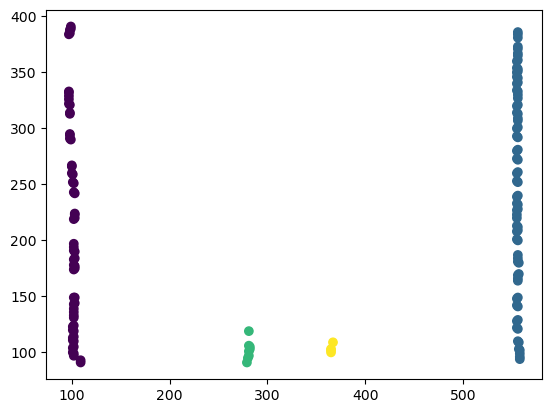

In [64]:
labels0 = _kmeans(scaled0, 4)
labelled = np.hstack((starts0, labels0[:, np.newaxis]))
print(silhouette_score(scaled0, labels0))
plt.scatter(labelled[:,0], labelled[:,1], c=labelled[:,2])

0.8928919598565664
0.9635745877620499
0.9770443075592254
0.810555982787082


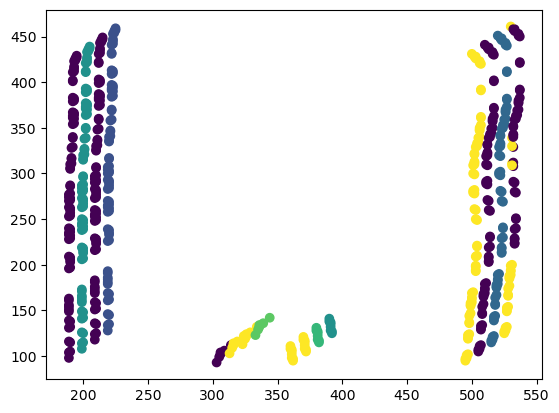

In [193]:
for i in range(2, 6):
    labels0 = _kmeans(scaled0, i)
    labelled = np.hstack((starts0, labels0[:, np.newaxis])) + i * 10
    print(silhouette_score(scaled0, labels0))
    plt.scatter(labelled[:,0], labelled[:,1], c=labelled[:,2] / i)


In [84]:
n_sides_wall = [2, 4, 6]
d0, d1 = {}, {}

sil_max = -2
for n in n_sides_wall:
    label0 = _kmeans(split0, n_clusters=n)
    label1 = _kmeans(split1, n_clusters=n)

    sil0 = silhouette_score(starts0, label0)
    sil1 = silhouette_score(starts0, label0)
    sil_score = np.max((sil0, sil1))
    if sil_score > sil_max:
        sil_max = sil_score
        best_n = n
best_n

2

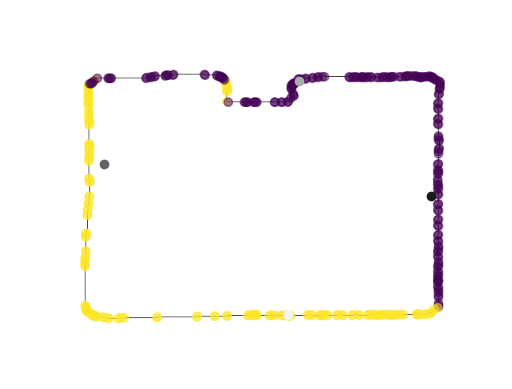

In [65]:
km = KMeans(n_clusters=2)
km.fit(starts0)
km.predict(starts0)
label0 = km.labels_

km = KMeans(n_clusters=2)
km.fit(starts1)
km.predict(starts1)
label1 = km.labels_

starts0 = np.hstack((starts0, label0[:, np.newaxis]))
starts1 = np.hstack((starts1, label1[:, np.newaxis]))

s00 = np.mean(starts0[starts0[:,2] == 0.][:,:2], axis=0)
s01 = np.mean(starts0[starts0[:,2] == 1.][:,:2], axis=0)


s10 = np.mean(starts1[starts1[:,2] == 0.][:,:2], axis=0)
s11 = np.mean(starts1[starts1[:,2] == 1.][:,:2], axis=0)

plt.scatter(starts0[:,0], starts0[:,1], c=label0, alpha=0.5)
plt.scatter(starts1[:,0], starts1[:,1], c=label1, alpha=0.5)

for i, j in enumerate([s00, s01, s10, s11]):
    plt.scatter(j[0], j[1], c=f'{i/3.5+0.1}')
plt.imshow(edge, cmap='Greys')
plt.axis('off')
plt.show()

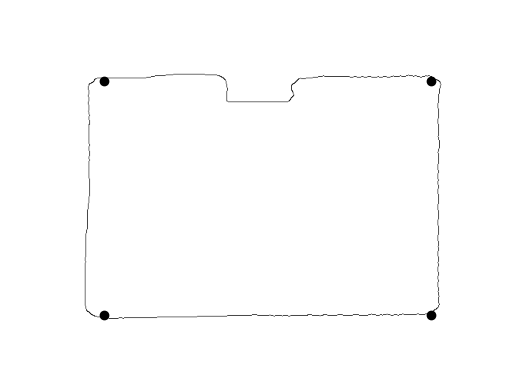

array([[453.25689655,   0.        ],
       [453.25689655, 303.58733133],
       [ 28.52832512,   0.        ],
       [ 28.52832512, 303.58733133]])

In [66]:
points = np.zeros((1, 2))
a = np.vstack((b0, -b1)).T
for i0 in [s00, s01]:
    for i1 in [s10, s11]:
        b = i0[:, np.newaxis] - i1[:, np.newaxis]
        x = np.linalg.solve(a, b)
        x = i1 - x[1] * b1
        points = np.vstack((points, x[np.newaxis, :]))
points = points[1:, :]
plt.imshow(edge, cmap='Greys')
plt.scatter(points[:,0], points[:,1], c='k')
plt.axis('off')
plt.show()
points - points.min()

In [54]:
ceil[:,0].max(),ceil[:,0].min(),ceil[:,1].max(),ceil[:,1].min()

ssize = 250
m = ceil[:,1].min()
diff = (ceil[:,1].max() - m) / ssize
for i in range(ssize):
    temp = ceil[:,0][np.logical_and(ceil[:,1] > (i*diff + m),ceil[:,1] < (i+1)*((i+1)*diff + m))]

In [67]:
xmin_c, xmax_c = np.min(ceil[:, 0]), np.max(ceil[:, 0])
ymin_c, ymax_c = np.min(ceil[:, 1]), np.max(ceil[:, 1])
shape_c = xmax_c - xmin_c, ymax_c - ymin_c

xmin_s, xmax_s = np.min(starts[:, 0]), np.max(starts[:, 0])
ymin_s, ymax_s = np.min(starts[:, 1]), np.max(starts[:, 1])
shape_s = xmax_s - xmin_s, ymax_s - ymin_s

factor_x = shape_s[0] / shape_c[0]
factor_y = shape_s[1] / shape_c[1]
factor = np.mean((factor_y, factor_x))
adj = 0.98

corners = (points - points.min()) / factor
# plt.scatter(ceil[:,0], ceil[:, 1], color='k', alpha=0.002)
# plt.scatter(corners[:,0], corners[:, 1], color='r')
# plt.axis('equal')
flat = corners.flatten()
matr = np.vstack((flat, np.zeros_like(flat))).T

km = KMeans(n_clusters=4)
km.fit(matr)
km.predict(matr)
lab = km.labels_

d = {}
for i in range(4):
    d[i] = np.min(flat[lab == i])
for i, j in enumerate(lab):
    flat[i] = d[j]
flat.reshape((4,2))

array([[0.97793192, 0.        ],
       [0.97793192, 0.65500987],
       [0.06155176, 0.        ],
       [0.06155176, 0.65500987]])